<a href="https://colab.research.google.com/github/KatarzynaSeyda/MachineLearning/blob/main/Projekt_Machine_Learning_XGBoostipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ================================ Importy i ustawienia ================================================================================
!pip install group_lasso
!pip install optuna
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from group_lasso import GroupLasso
import optuna
from optuna.visualization import plot_optimization_history
import xgboost as xgb
import shap


from google.colab import drive
drive.mount('/content/drive')

#====================================================================================================
def statistics(dataset: pd.DataFrame, name: str):
    # Statystyki opisowe pandas
    data_stats = dataset.describe(include='all').round(2)
    # Dodatkowe statystyki
    data_additional_info = pd.DataFrame({
        "Data Types": dataset.dtypes,
        "Missing Values": dataset.isnull().sum(),
        "Missing Values (%)": (dataset.isnull().sum() / len(dataset) * 100).round(1)
    })
    # Scalanie wszystkich statystyk
    all_stats = pd.concat([data_stats, data_additional_info.T])
    print("\nStatystyki dla danych: ", name)
    print(all_stats)


#====================================================================================================
def create_lags(df: pd.DataFrame, lags: int, sektor: str):
    lagged_data = []
    for column in df.columns:
        for lag in range(1, lags + 1):
            lagged_col = df[column].shift(lag)  # Zmienna opóźniona
            lagged_data.append(lagged_col.rename(f"{column}_lag_{lag}"))

    # Połączenie wszystkich Series w jeden DataFrame
    lagged_data_df = pd.concat(lagged_data, axis=1)

    # Zmienna Y nieopóźniona
    df_y = df[sektor]

    # Połączenie
    df_lagged = pd.concat([df_y, lagged_data_df],
                          axis=1)  # tylko zmienne opóźnione (nie bierzemy zmiennych z aktualnego dnia) + Y nieopoźniony (do prognozy)
    df_lagged = df_lagged.dropna()
    return df_lagged

#====================================================================================================
#Do Optuny:
def sliding_window_split(X, y, train_size, test_size):
    # Pętla przesuwająca się
    # Okno treningowe przesuwa się w każdej iteracji, w miarę jak start przesuwa się do przodu.
    for start in range(len(X) - train_size - test_size + 1):
        X_train = X[start: start + train_size]
        y_train = y[start: start + train_size]
        X_test = X[start + train_size: start + train_size + test_size]
        y_test = y[start + train_size: start + train_size + test_size]
        yield X_train, y_train, X_test, y_test      #yield zwraca kolejne wyniki, jeden po drugim



def objective(trial,X,y,train_size: int,test_size: int):
    # Przestrzeń poszukiwań hiperparametrów
    param = {
        "objective": "reg:squarederror",  # Funkcja kosztu dla regresji
        "eval_metric": "rmse",  # RMSE do oceny modelu
        "max_depth": 6,  # Głębokość drzewa decyzyjnego (od, do)
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True), # Szybkość uczenia (od, do), LR wpływa na długość kroku iteracji
        "gamma": 1, # Minimalna redukcja kosztu, wymagana do podziału węzła, im wyższe tym mniej podziałów (jeśli GAIN<Gamma to nie idz dalej)
        "reg_alpha": trial.suggest_float("reg_alpha", 1, 5),  # Redukcja wag cech nieistotnych, pomaga w selekcji cech (zapobiegamy overfittingowi)
        "reg_lambda": trial.suggest_float("reg_lambda", 1, 5)   # Ograniczenie wielkości wag, im lambda większa tym Similarity Score mniejszy, model się uogólnia (zapobiegamy overfittingowi)
        }

    rmse_scores = []
    # Trening modelu
    for X_train, y_train, X_test, y_test in sliding_window_split(X, y, train_size, test_size):
        model = xgb.XGBRegressor(**param)
        model.fit(X_train,y_train)
        # Ocena modelu (RMSE na zbiorze testowym)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(rmse)

    mean_rmse = sum(rmse_scores) / len(rmse_scores)
    return mean_rmse



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# ================================DANE WSTĘPNE DO ANALIZY ================================================================================

LAG_WEEKS = 5  # Liczba tygodni wstecz, które mogą wpływać na prognozę

TRAIN_SIZE = 100  # Liczba próbek w oknie treningowym
TEST_SIZE = 15  # Liczba próbek w oknie testowym

ITERATIONS = 100  # Liczba iteracji Optuny do optymalizacji hiperparametrów





In [4]:
# ================================ Dane źródłowe z kaggle ================================
# Zestaw danych

data = pd.read_csv('/content/drive/MyDrive/World-Stock-Prices-Dataset.csv', sep=',')

# ================================ Wstępna analiza danych ===================================================================

data["Date"] = pd.to_datetime(data["Date"], utc=True)  # Zmiana formatu daty aby móc analizować szeregi czasowe
newest_date = data.iloc[1]['Date'].date()  # Najnowsza data w pobranym zbiorze danych, tylko data bez godziny

print('\n~~~~~~~~~~~~~~~~~~~~ WITAJ W ANALIZIE DANYCH WORLD STOCK PRICES DATASET! ~~~~~~~~~~~~~~~~~~~~')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Najnowsze dane z dnia: ', newest_date, ' ~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

# Połączenie niektórych kategorii w jedną z uwagi na podobieństwo i małą liczność spółek w danych grupach
data["Industry_Tag"] = data["Industry_Tag"].replace("financial services", "finance")
data["Industry_Tag"] = data["Industry_Tag"].replace("food & beverage", "food")
data["Industry_Tag"] = data["Industry_Tag"].replace("music", "entertainment")

industries = data['Industry_Tag'].unique()
print('\n Sektory biorące udział w analizie: \n', industries)

# Wersja z wyborem sektora
# while True:
#     sektor_Y = input('Napisz nazwę sektora do analizy: ')
#     if sektor_Y in industries:
#         print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Sektor analizowany: ', sektor_Y, '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
#         break
#     else:
#         print("!!! Niepoprawne słowo !!! Spróbuj ponownie.")

sektor_Y='footwear'
print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Sektor analizowany: ', sektor_Y, '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

statistics(data, 'dane źródłowe z csv')


~~~~~~~~~~~~~~~~~~~~ WITAJ W ANALIZIE DANYCH WORLD STOCK PRICES DATASET! ~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Najnowsze dane z dnia:  2024-12-03  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~

 Sektory biorące udział w analizie: 
 ['fitness' 'automotive' 'apparel' 'finance' 'technology' 'consumer goods'
 'luxury goods' 'hospitality' 'food' 'retail' 'healthcare'
 'cryptocurrency' 'logistics' 'manufacturing' 'footwear' 'entertainment'
 'gaming' 'aviation' 'e-commerce' 'social media']

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Sektor analizowany:  footwear ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Statystyki dla danych:  dane źródłowe z csv
                                                   Date      Open      High  \
count                                            299749  299749.0  299749.0   
unique                                              NaN       NaN       NaN   
top                                                 NaN       NaN       NaN   
freq                                                NaN 

In [5]:
print("\n~~~~~~~~~~~~~~~~~~~~ PRZYGOTOWANIE DANYCH PER SEKTOR ~~~~~~~~~~~~~~~~~~~~")

# Obliczenie średniej ważonej ceny zamknięcia dla każdego sektora (Industry_Tag)
data_industry = (
    data.assign(weighted_close=data['Close'] * data['Volume'])  # Dodanie kolumny z wagą
    .groupby(['Date', 'Industry_Tag'])[['weighted_close', 'Volume']]  # Grupowanie
    .sum()  # Sumowanie wag i wolumenów w grupach
    .eval('weighted_close / Volume')  # Obliczenie średniej ważonej
    .unstack()  # Przekształcenie grup w kolumny dla każdego 'Industry_Tag'
)

# Przygotowanie danych tygodniowych
days_resampling = {
    0: 'W-MON',  # Poniedziałek
    1: 'W-TUE',  # Wtorek
    2: 'W-WED',  # Środa
    3: 'W-THU',  # Czwartek
    4: 'W-FRI',  # Piątek
    5: 'W-SAT',  # Sobota
    6: 'W-SUN'  # Niedziela
}
# Reguła resamplingu w zależności od ostatniego notowania
ostatni_dzien = newest_date.weekday()
regula = days_resampling[ostatni_dzien]
data_industry_weekly = data_industry.resample(regula).mean()

data_industry_weekly = data_industry_weekly.reset_index()

print("\nŚrednia ważona cen zamknięcia dla każdego sektora (tygodniowo) - najnowsze dane:")
print(data_industry_weekly.tail())
statistics(data_industry_weekly, 'tygodniowe indeksy sektorowe')



~~~~~~~~~~~~~~~~~~~~ PRZYGOTOWANIE DANYCH PER SEKTOR ~~~~~~~~~~~~~~~~~~~~

Średnia ważona cen zamknięcia dla każdego sektora (tygodniowo) - najnowsze dane:
Industry_Tag                      Date    apparel  automotive   aviation  \
1296         2024-11-05 00:00:00+00:00  60.840973  245.945578  46.005654   
1297         2024-11-12 00:00:00+00:00  58.616755  312.480657  48.796450   
1298         2024-11-19 00:00:00+00:00  59.840497  323.095390  50.773134   
1299         2024-11-26 00:00:00+00:00  59.166824  332.636238  49.789226   
1300         2024-12-03 00:00:00+00:00  56.952920  335.581679  47.426255   

Industry_Tag  consumer goods  cryptocurrency  e-commerce  entertainment  \
1296              122.183459      190.820004  184.605311     276.290655   
1297              122.894053      284.799997  178.907814     296.195942   
1298              123.985286      303.878003  186.637646     263.007317   
1299              133.359133      305.078009  185.034996     381.087291   
1300       

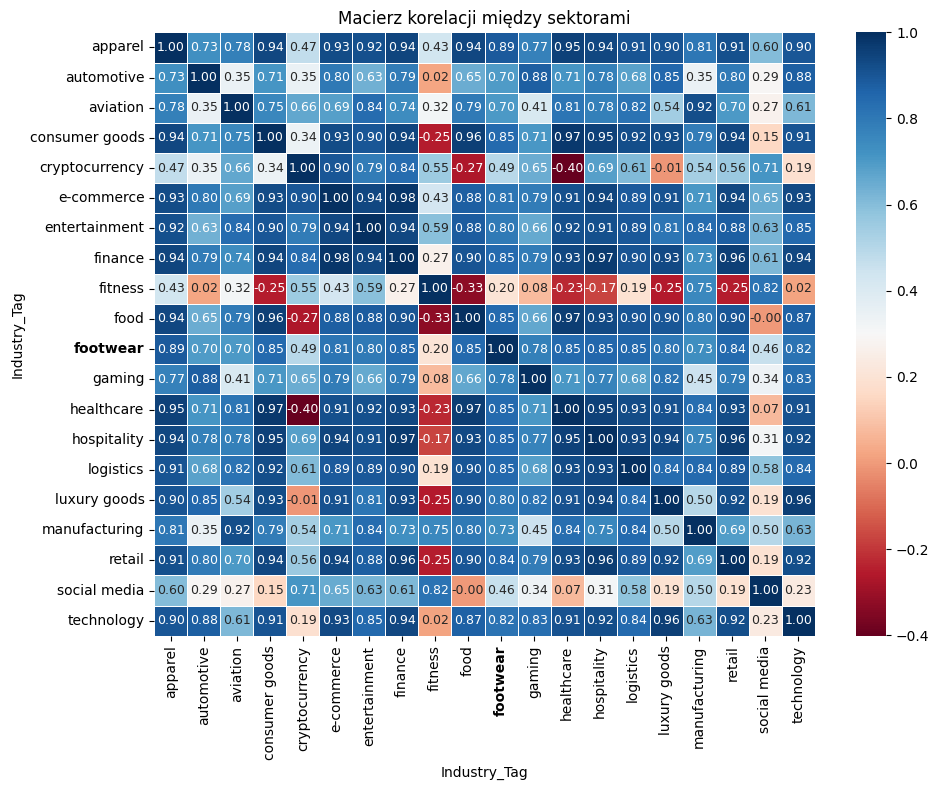

In [6]:
# ================================= Analiza korelacji =================================

# Korelacja
numeric_data = data_industry_weekly.select_dtypes(include='number')
correlation_matrix = numeric_data.corr()


plt.figure(figsize=(10, 8))
macierz = sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', fmt='.2f', linewidths=0.5,
                          annot_kws={"size": 9})

# Pogrubienie wybranej nazwy na osi X
for label in macierz.get_xticklabels():
    if label.get_text() == sektor_Y:
        label.set_weight('bold')
        label.set_fontsize(10)

# Pogrubienie wybranej nazwy na osi Y
for label in macierz.get_yticklabels():
    if label.get_text() == sektor_Y:
        label.set_weight('bold')
        label.set_fontsize(10)

plt.title(f'Macierz korelacji między sektorami')
plt.tight_layout()
plt.show()



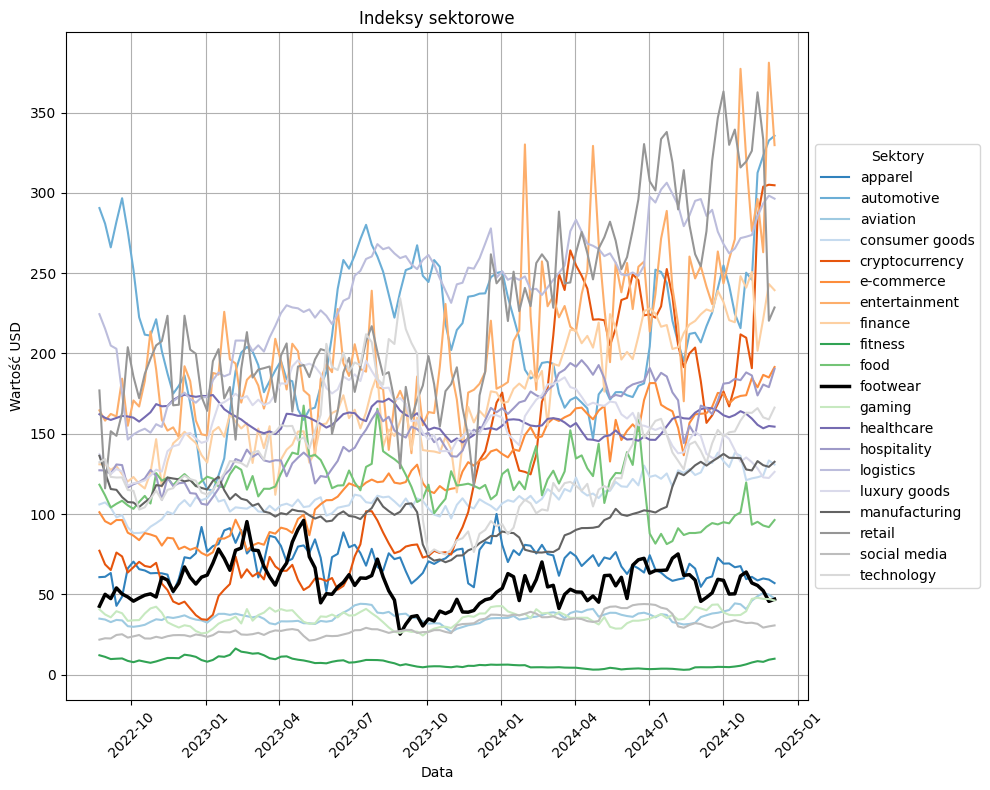

In [7]:
# ============================= Wykres liniowy =============================

# Wykres liniowy tylko dla wybranego okna czasowego (train+test)
data_industry_shortened = data_industry_weekly.tail(TRAIN_SIZE + TEST_SIZE + LAG_WEEKS)

plt.figure(figsize=(10, 8))
palette = sns.color_palette("tab20c", n_colors=len(data_industry_shortened.columns[1:]))

# Iterowanie po zmiennych i ich wykres
for i, column in enumerate(data_industry_shortened.columns[1:]):  # iterujemy po indeksie oraz po nazwie kolumny
    if column == sektor_Y:
        # Wyróżnienie koloru i grubości dla wybranej zmiennej
        plt.plot(data_industry_shortened['Date'], data_industry_shortened[column], label=column, color="black", linewidth=2.5)
    else:
        plt.plot(data_industry_shortened['Date'], data_industry_shortened[column], label=column, color=palette[i])

# Dostosowanie wykresu
plt.title('Indeksy sektorowe')
plt.xlabel('Data')
plt.ylabel('Wartość USD')
plt.legend(title='Sektory', loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.xticks(rotation=45)

# Wyświetlanie wykresu
plt.tight_layout()
plt.show()



In [8]:
# =============================== Zmienne opóźnione ===============================================================================
print('\n~~~~~~~~~~~~~~~~~~~~ PRZYGOTOWANIE DANYCH OPÓŹNIONYCH (' + str(LAG_WEEKS) + ' weeks) ~~~~~~~~~~~~~~~~~~~~')

data_industry_filtered = data_industry_weekly.drop(columns='Date')  # usuwamy kolumnę z datą

# Utworzenie zmiennych opóźnionych (do szeregu czasowego żeby móc wykorzystać xgboost)
data_lagged = create_lags(data_industry_filtered, LAG_WEEKS, sektor_Y)
data_lagged = data_lagged.dropna()

statistics(data_lagged, 'dane z indeksami sektorowymi i opóźnieniami')


# ============================= Przygotowanie zbioru do modelowania ================================================================

X = data_lagged.drop(columns=sektor_Y)  # Wszystkie kolumny oprócz Y
y = data_lagged[sektor_Y]  # Zmienna docelowa



~~~~~~~~~~~~~~~~~~~~ PRZYGOTOWANIE DANYCH OPÓŹNIONYCH (5 weeks) ~~~~~~~~~~~~~~~~~~~~

Statystyki dla danych:  dane z indeksami sektorowymi i opóźnieniami
                   footwear apparel_lag_1 apparel_lag_2 apparel_lag_3  \
count                 185.0         185.0         185.0         185.0   
mean                  60.66         76.56         76.83         77.04   
std                   17.92         15.85         15.98         16.01   
min                   25.19         42.81         42.81         42.81   
25%                   46.96         65.33         65.34         65.63   
50%                   58.83         74.21         74.35         74.36   
75%                   73.36         86.08          86.1         86.45   
max                  117.18        123.88        123.88        123.88   
Data Types          float64       float64       float64       float64   
Missing Values            0             0             0             0   
Missing Values (%)      0.0           0.0 

In [9]:
# ============================= Group Lasso do wyboru zmiennych =================================================================
print('\n~~~~~~~~~~~~~~~~~~~~ GRUPOWANIE ZMIENNYCH (GROUP LASSO) ~~~~~~~~~~~~~~~~~~~~')
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Tworzenie słownika grup i przypisywanie kolumn
grouped_X = {f"{group}_group": [col for col in X.columns if group in col] for group in industries}

# Wyświetlenie wyników
for group_name, cols in grouped_X.items():
    print(f"{group_name}: {cols}")

# Numerowanie grup
group_map = {group_name: i for i, group_name in enumerate(grouped_X.keys())}

# Lista grup dla każdej kolumny (konwersja do listy)
column_to_group = []
for group_name, columns in grouped_X.items():
    group_number = group_map[group_name]
    column_to_group.extend([group_number] * len(columns))

group_lasso = GroupLasso(
    groups=column_to_group,  # Lista numerów grup
    group_reg=0.1,          # Siła regularyzacji dla grup, jeśli dana grupa cech zostanie uznana za nieistotną, wszystkie cechy w tej grupie będą miały współczynniki równe 0, a żadna z nich nie znajdzie się w selected_features
    l1_reg=0.1,            # Siła regularyzacji L1, może wyzerować współczynniki pojedynczych cech w ramach grupy, nawet jeśli sama grupa jako całość jest zachowana
    scale_reg="none",       # Skalowanie kar w zależności od wielkości grupy (brak bo grupy są takie same wielkościowo)
    supress_warning=True,
    n_iter=5000
)

group_lasso.fit(X_scaled, y)

# Wybrane zmienne na podstawie współczynników
coefficients = group_lasso.coef_.ravel()  # Przekształcenie na wektor 1-wymiarowy
features_lasso = X.columns[coefficients != 0]

# Tworzenie DataFrame z nazwami cech i ich współczynnikami
coefficients_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": coefficients})

coefficients_df = coefficients_df[coefficients_df["Coefficient"] != 0]

print('\nWybrane cechy po analizie Group Lasso: \n', coefficients_df.sort_values(by="Feature", ascending=True))

X_po_lasso = X[features_lasso]  # Tylko zmienne wybrane w poprzednim kroku




~~~~~~~~~~~~~~~~~~~~ GRUPOWANIE ZMIENNYCH (GROUP LASSO) ~~~~~~~~~~~~~~~~~~~~
fitness_group: ['fitness_lag_1', 'fitness_lag_2', 'fitness_lag_3', 'fitness_lag_4', 'fitness_lag_5']
automotive_group: ['automotive_lag_1', 'automotive_lag_2', 'automotive_lag_3', 'automotive_lag_4', 'automotive_lag_5']
apparel_group: ['apparel_lag_1', 'apparel_lag_2', 'apparel_lag_3', 'apparel_lag_4', 'apparel_lag_5']
finance_group: ['finance_lag_1', 'finance_lag_2', 'finance_lag_3', 'finance_lag_4', 'finance_lag_5']
technology_group: ['technology_lag_1', 'technology_lag_2', 'technology_lag_3', 'technology_lag_4', 'technology_lag_5']
consumer goods_group: ['consumer goods_lag_1', 'consumer goods_lag_2', 'consumer goods_lag_3', 'consumer goods_lag_4', 'consumer goods_lag_5']
luxury goods_group: ['luxury goods_lag_1', 'luxury goods_lag_2', 'luxury goods_lag_3', 'luxury goods_lag_4', 'luxury goods_lag_5']
hospitality_group: ['hospitality_lag_1', 'hospitality_lag_2', 'hospitality_lag_3', 'hospitality_lag_4', 'ho

In [10]:
#=============================== Podział na zbiór treningowy i testowy ===================================================================
#Ze względu na analizę szeregu czasowego nie możemy podzielić zbioru w sposób losowy
#Rozmiary TRAIN_SIZE i TEST_SIZE podano na początku skryptu

X_train = X_po_lasso[-(TRAIN_SIZE + TEST_SIZE):-TEST_SIZE]  # Ostatnie TRAIN_SIZE próbek przed testowymi
y_train = y[-(TRAIN_SIZE + TEST_SIZE):-TEST_SIZE]
X_test = X_po_lasso[-TEST_SIZE:]    #najnowsze próbki (TEST_SIZE)
y_test = y[-TEST_SIZE:]

print('\n~~~~~~~~~~~~~~~~~~~~ Zbiór treningowy i testowy po analize Group Lasso ~~~~~~~~~~~~~~~~~~~~')
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)




~~~~~~~~~~~~~~~~~~~~ Zbiór treningowy i testowy po analize Group Lasso ~~~~~~~~~~~~~~~~~~~~
X_train:  (100, 21)
y_train:  (100,)
X_test:  (15, 21)
y_test:  (15,)


In [11]:
# ================ Model XGBoost - do kolejnej selekcji zmiennych według feature importance  ===============================

model=xgb.XGBRegressor()
model.fit(X_train, y_train)

# Predykcje
y_pred = model.predict(X_test)

# Gain importance
gain_importance = model.get_booster().get_score(importance_type='gain')

# Tworzenie DataFrame na podstawie nazwy cech i ich Gain z gain_importance
importance_df = pd.DataFrame(list(gain_importance.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Obliczenie skumulowanej ważności
importance_df['Cumulative_Importance'] = importance_df['Importance'].cumsum() / importance_df['Importance'].sum()

# Wybranie cech do 99% skumulowanej ważności (usunięcie zmiennych najmniej ważnych - szum)
selected_features = importance_df[importance_df['Cumulative_Importance'] <= 0.99]['Feature'].tolist()

print("\nWybrano cechy według Feature Importance: ", len(selected_features), selected_features)

X_final = X_po_lasso[selected_features]

print('\nZaktualizowany zbiór X:', X_final.shape)


Wybrano cechy według Feature Importance:  18 ['footwear_lag_1', 'social media_lag_1', 'fitness_lag_1', 'social media_lag_2', 'social media_lag_4', 'social media_lag_3', 'footwear_lag_5', 'fitness_lag_2', 'fitness_lag_4', 'fitness_lag_5', 'entertainment_lag_1', 'entertainment_lag_2', 'fitness_lag_3', 'footwear_lag_2', 'apparel_lag_4', 'apparel_lag_5', 'apparel_lag_3', 'apparel_lag_1']

Zaktualizowany zbiór X: (185, 18)


In [12]:
# ============================ Optuna do optymalizacji hiperparametrów ============================================================================
print("\n~~~~~~~~~~~~~~~~~~~~ Optymalizacja hiperparametrów modelu ~~~~~~~~~~~~~~~~~~~~")
study = optuna.create_study(direction="minimize")

study.optimize(lambda trial: objective(trial, X_final, y, TRAIN_SIZE, TEST_SIZE), n_trials=ITERATIONS, timeout=3600, n_jobs=10)

# Wizualizacja poprawy wartości celu w czasie
plot_optimization_history(study)

# Najlepsze parametry
print('\nNajlepsze parametry: ', study.best_params)


[I 2024-12-04 19:23:22,698] A new study created in memory with name: no-name-466c9a56-d810-4c26-8a27-9e232f7e250d



~~~~~~~~~~~~~~~~~~~~ Optymalizacja hiperparametrów modelu ~~~~~~~~~~~~~~~~~~~~


[I 2024-12-04 19:25:59,242] Trial 2 finished with value: 11.095732448610075 and parameters: {'learning_rate': 0.0723077201978778, 'reg_alpha': 3.262758655215564, 'reg_lambda': 4.163625786052361}. Best is trial 2 with value: 11.095732448610075.
[I 2024-12-04 19:26:06,446] Trial 6 finished with value: 10.90070769112746 and parameters: {'learning_rate': 0.06281427825129436, 'reg_alpha': 1.2893402142502213, 'reg_lambda': 4.416151464719044}. Best is trial 6 with value: 10.90070769112746.
[I 2024-12-04 19:26:06,503] Trial 0 finished with value: 10.620289452555381 and parameters: {'learning_rate': 0.05130789562628389, 'reg_alpha': 3.7854469372201174, 'reg_lambda': 2.2327186392107943}. Best is trial 0 with value: 10.620289452555381.
[I 2024-12-04 19:26:07,352] Trial 8 finished with value: 10.782366307478913 and parameters: {'learning_rate': 0.05525644714947493, 'reg_alpha': 1.4654030803920066, 'reg_lambda': 3.9303035220357807}. Best is trial 0 with value: 10.620289452555381.
[I 2024-12-04 19:2


Najlepsze parametry:  {'learning_rate': 0.017543063327868983, 'reg_alpha': 1.0125398666368346, 'reg_lambda': 1.173121711399551}



~~~~~~~~~~~~~~~~~~~~ Zbiór treningowy i testowy do XGBoost (final model) ~~~~~~~~~~~~~~~~~~~~
X_train:  (100, 18)
y_train:  (100,)
X_test:  (15, 18)
y_test:  (15,)

RMSE modelu (trening): 3.94
MAPE modelu (trening): 5.62 %

RMSE modelu (okres testowy): 7.17
MAPE modelu (okres testowy): 11.45 %


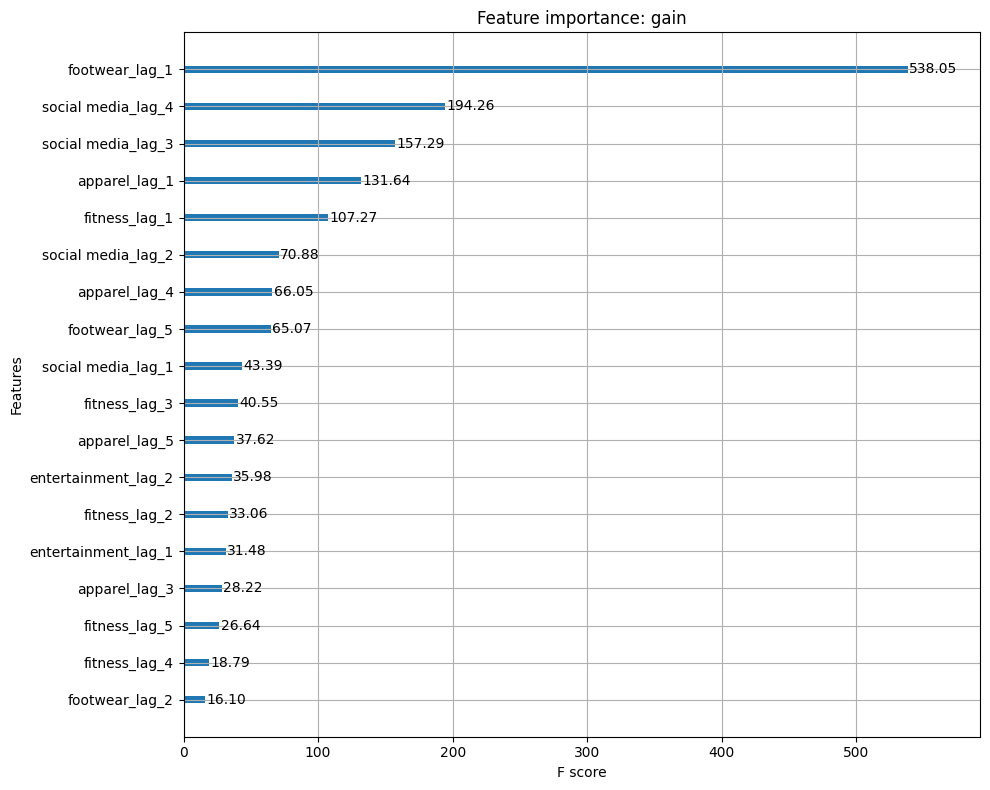

In [13]:
# =============================== Model XGBoost - trening ===============================================================================

best_params = study.best_params  # hiperparametry z Optuny

print('\n~~~~~~~~~~~~~~~~~~~~ Zbiór treningowy i testowy do XGBoost (final model) ~~~~~~~~~~~~~~~~~~~~')
X_train = X_final[-(TRAIN_SIZE + TEST_SIZE):-TEST_SIZE]  #najnowsze TRAIN_SIZE próbek przed testowymi
y_train = y[-(TRAIN_SIZE + TEST_SIZE):-TEST_SIZE]
X_test = X_final[-TEST_SIZE:]    #najnowsze próbki (TEST_SIZE)
y_test = y[-TEST_SIZE:]

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

y_pred_train=final_model.predict(X_train)

train_rmse = np.sqrt(np.mean((y_pred_train - y_train) ** 2))
train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
print('\nRMSE modelu (trening):', round(train_rmse, 2))
print('MAPE modelu (trening):', round(train_mape, 2), '%')

# Prognoza i ocena
y_pred = final_model.predict(X_test)
final_rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
final_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('\nRMSE modelu (okres testowy):', round(final_rmse, 2))
print('MAPE modelu (okres testowy):', round(final_mape, 2), '%')

fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(final_model, importance_type='gain', ax=ax,values_format='{v:.2f}')
ax.set_title('Feature importance: gain')
plt.tight_layout()
plt.show()


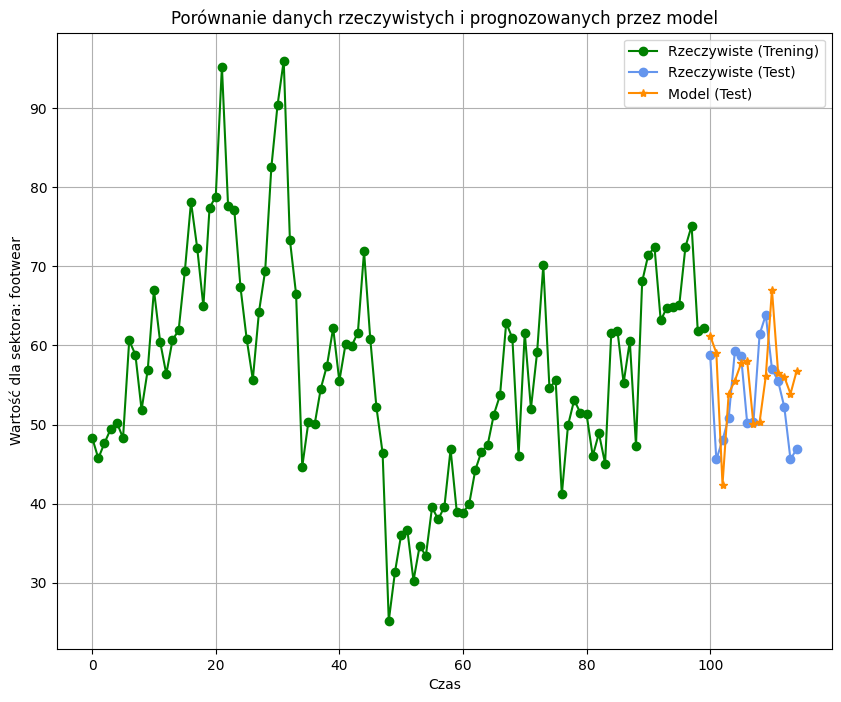

In [17]:
# ============================= Model XGBoost vs rzeczywiste WYKRES ========================================================================================
# Indeksy czasowe dla danych treningowych i testowych
train_steps = np.arange(len(y_train))  # Indeksy dla treningu
test_steps = np.arange(len(y_train), len(y_train) + len(y_test))  # Indeksy dla testu (kontynuacja po treningu)


plt.figure(figsize=(10, 8))

# Rzeczywiste dane
plt.plot(train_steps, y_train, label="Rzeczywiste (Trening)", color="green", marker='o')
plt.plot(test_steps, y_test, label="Rzeczywiste (Test)", color="cornflowerblue", marker='o')

# Prognozy modelu na zbiorze testowym
plt.plot(test_steps, y_pred, label="Model (Test)", color="darkorange", marker='*')

# Dostosowanie wykresu
plt.title("Porównanie danych rzeczywistych i prognozowanych przez model")
plt.xlabel("Czas")
plt.ylabel(f'Wartość dla sektora: {sektor_Y}')
plt.legend()
plt.grid(True)
plt.show()


========================== Shapley values ==========================


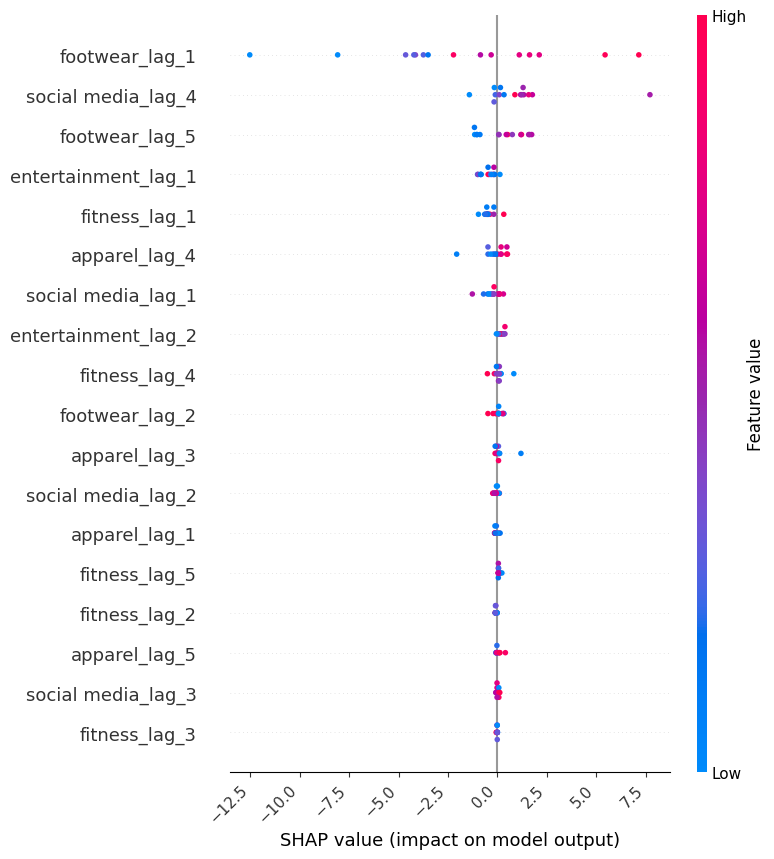

========================== Waterfall Plot ==========================


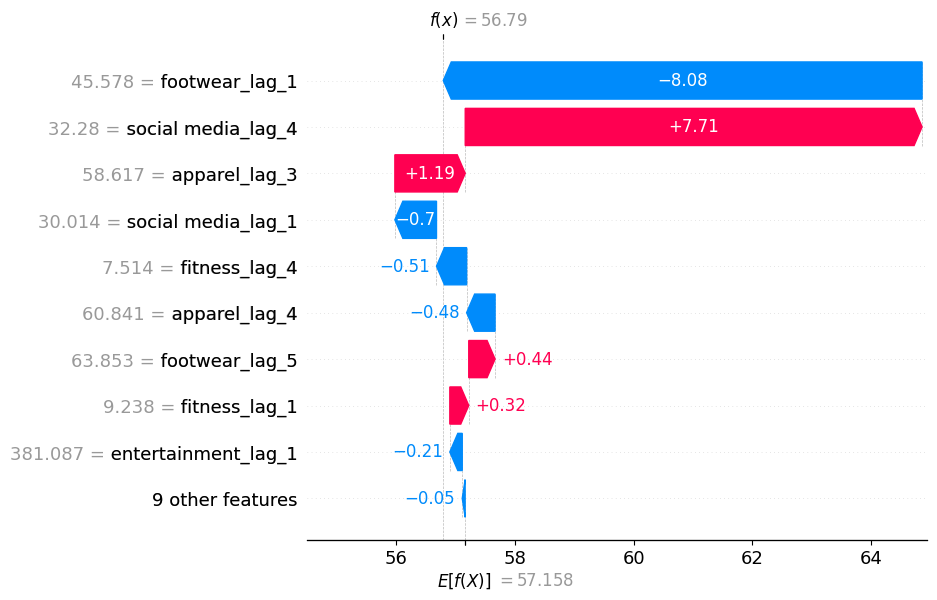

<Figure size 640x480 with 0 Axes>

In [20]:
# ============================= Shapley values ====================================================================================================
print('========================== Shapley values ==========================')
explainer = shap.TreeExplainer(final_model)
shap_values = explainer(X_test)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, show=False)   #Wpływ cech na przewidywaną wartość modelu
plt.xticks(rotation=45, ha='right')     # Ustawienie kąta nachylenia etykiet osi
plt.tight_layout()                      # Automatyczne dopasowanie marginesów
plt.show()

# Waterfall Plot (wpływ poszczególnych zmiennych na wartość Y - dla ostatniej linii w zbiorze testowym)
print('========================== Waterfall Plot ==========================')
plt.figure(figsize=(10, 8))
shap.plots.waterfall(shap_values[-1])
plt.tight_layout()



~~~~~~~~~~~~~~~~~~~~ PROGNOZA NA TYDZIEŃ: 2024-12-04 - 2024-12-10 ~~~~~~~~~~~~~~~~~~~~

Prognoza wartości indeksu:  [38.920956]
Wartość indeksu w obecnym tygodniu: 46.92396281444694

Rekomendacja dla sektora footwear: SPRZEDAJ 🔴


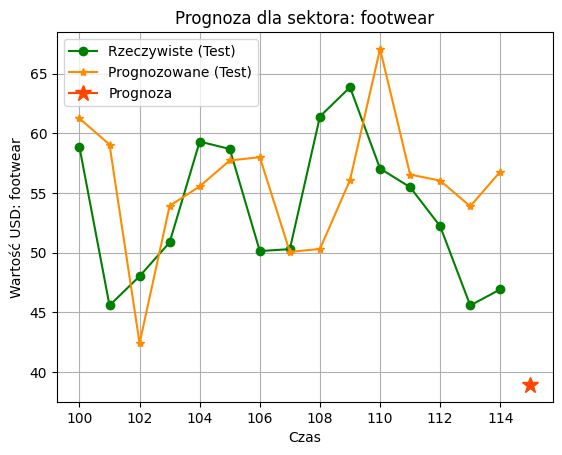


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ KONIEC ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [21]:
# ============================== PROGNOZA NA KOLEJNY TYDZIEŃ ================================================================================================
data_od = newest_date + timedelta(days=1)
data_do = data_od + timedelta(days=6)
print(f'\n~~~~~~~~~~~~~~~~~~~~ PROGNOZA NA TYDZIEŃ: {data_od} - {data_do} ~~~~~~~~~~~~~~~~~~~~')

# Tworzenie nowego wiersza
new_row = {}

for col in X_test.columns:
    lag_number = int(col[-1])  # Pobieranie numeru lag
    if lag_number == 1:
        # Wartości dla "_lag_1" pochodzą z danych pierwotnych (bez opóźnień)
        col_orginal = col.split("_")[0]
        new_row[col] = data_industry_weekly[col_orginal].iloc[-1]
    else:
        # Wartości dla "_lag_2", "_lag_3", itd. pochodzą  z kolumny o numerze lag-1 ze zbioru danych opóźnionych
        previous_col = col.replace(f"_lag_{lag_number}", f"_lag_{lag_number - 1}")
        new_row[col] = data_lagged[previous_col].iloc[-1]

new_row_df = pd.DataFrame([new_row])  # Do dataframe
y_pred_next = final_model.predict(new_row_df)
print("\nPrognoza wartości indeksu: ", y_pred_next)

y_pred_last = y_test.iloc[-1]
print('Wartość indeksu w obecnym tygodniu:', y_pred_last)
if y_pred_next > y_pred_last:
    print(f'\nRekomendacja dla sektora {sektor_Y}: KUP \U0001F7E2')
else:
    print(f'\nRekomendacja dla sektora {sektor_Y}: SPRZEDAJ \U0001F534')

# Wykres z prognozą na kolejny tydzień
# Indeksy czasowe dla danych testowych i prognozy
test_steps = np.arange(len(y_train), len(y_train) + len(y_test))  # Indeksy dla testu (kontynuacja po treningu)
progn_steps = np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 1)  # Indeks dla predykcji (kontynuacja po testowym)

# Rzeczywiste dane
plt.plot(test_steps, y_test, label="Rzeczywiste (Test)", color="green", marker='o')
# Prognozy modelu na zbiorze testowym
plt.plot(test_steps, y_pred, label="Prognozowane (Test)", color="darkorange", marker='*')
# Prognoza kolejnego tygodnia
plt.plot(progn_steps, y_pred_next, label="Prognoza", color="orangered", marker='*', markersize=12)

# Dostosowanie wykresu
plt.title(f'Prognoza dla sektora: {sektor_Y}')
plt.xlabel("Czas")
plt.ylabel(f'Wartość USD: {sektor_Y}')
plt.legend()
plt.grid(True)
plt.show()

print(f'\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ KONIEC ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')